In [1]:
from tf_bind_8_dataset import TFBind8Dataset

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\Users\kroep\AppData\Local\Programs\Python\Python39\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


In [2]:
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
print('toggle')

toggle


### Load Data

In [4]:
dataset = TFBind8Dataset(
    base_path="C:/Users/kroep/Desktop/AI/ps_master/tfbind8_manual/data_from_huggingface/",
    transcription_factor="SIX6_REF_R1"
)

dataset.x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 2],
       ...,
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0]])

### Data Analysis

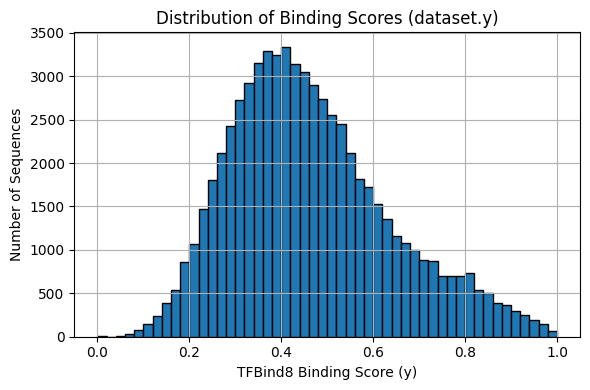

In [5]:
y_values = dataset.y.flatten()

def plot_y_values(y_values):
    # Plot the histogram of y values
    plt.figure(figsize=(6, 4))
    plt.hist(y_values, bins=50, edgecolor='black')
    plt.xlabel("TFBind8 Binding Score (y)")
    plt.ylabel("Number of Sequences")
    plt.title("Distribution of Binding Scores (dataset.y)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_y_values(y_values)

In [6]:
sequence_tuples = [tuple(seq) for seq in dataset.x]
seq_counts = Counter(sequence_tuples)
num_occurring_twice = sum(1 for count in seq_counts.values() if count == 2)

print(f"Number of sequences occurring exactly 2 times: {num_occurring_twice}")

Number of sequences occurring exactly 2 times: 256


In [7]:
seq_counts = Counter(sequence_tuples)
# seq_counts

In [8]:
dataset.x[1]

array([0, 0, 0, 0, 0, 0, 0, 1])

In [9]:
for i, sequ in enumerate(dataset.x):
    if (sequ == (0, 0, 2, 2, 1, 1, 3, 3)).all():
        print(f'index {i}: found {sequ} with a y-value of {dataset.y[i]}')

index 2608: found [0 0 2 2 1 1 3 3] with a y-value of [0.07736156]
index 35504: found [0 0 2 2 1 1 3 3] with a y-value of [0.07736156]


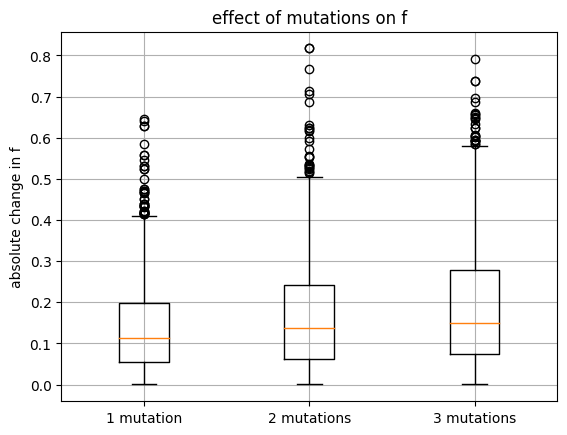

In [10]:
# get all mutated versions of a sequence with n mutations
def mutate_sequence(seq, num_mutations=1):
    seq = np.array(seq)
    mutated_seqs = []
    positions = list(range(len(seq)))

    for _ in range(25):  # 25 random combinations per sample
        pos_to_mutate = random.sample(positions, num_mutations)
        mutated = seq.copy()
        for pos in pos_to_mutate:
            original_base = seq[pos]
            possible_bases = [b for b in range(4) if b != original_base]
            mutated[pos] = random.choice(possible_bases)
        mutated_seqs.append(mutated)
    
    return mutated_seqs

# calculate avg absolute change in f for 50 randomly selected sequences
# when mutating a sequence up to 3 times
def compute_mutation_effects(dataset_x, dataset_y, mutation_counts=[1, 2, 3]):
    results = defaultdict(list)
    indices = np.random.choice(len(dataset_x), 50, replace=False)

    for idx in indices:
        original_seq = dataset_x[idx]
        original_y = dataset_y[idx][0]  # y is shape (N,1)

        for n_mut in mutation_counts:
            mutated_variants = mutate_sequence(original_seq, num_mutations=n_mut)

            for var in mutated_variants:
                matches = np.all(dataset_x == var, axis=1)
                if np.any(matches):
                    matched_y = dataset_y[matches][0][0]
                    delta = abs(original_y - matched_y)
                    results[n_mut].append(delta)
    
    return results

# Compute average changes
mutation_effects = compute_mutation_effects(dataset.x, dataset.y)

plt.boxplot([mutation_effects[n] for n in [1, 2, 3]], labels=["1 mutation", "2 mutations", "3 mutations"])
plt.ylabel("absolute change in f")
plt.title("effect of mutations on f")
plt.grid(True)
plt.show()

### Dataset Split
- Take a random sequence in the dataset and get all mutations up to 5. That is put into x_mutations, y_mutations.
- On the remaining data we do a dataset split for train, val and test.

In [11]:
# only select unique occurences
x_data, unique_indices = np.unique(dataset.x, axis=0, return_index=True)
y_data = dataset.y[unique_indices]

In [12]:
len(dataset.x) == len(x_data) + num_occurring_twice

True

In [13]:
# select a random anchor for the mutation dataset
np.random.seed(42)
anchor_idx = np.random.choice(len(x_data))
anchor_seq = x_data[anchor_idx]

# hamming distances for randomly selected anchorr
mutation_distances = np.array([np.sum(seq != anchor_seq) for seq in x_data])

# create mutation set (1–5 mutations away from anchor)
mutation_mask = (mutation_distances >= 1) & (mutation_distances <= 5)
x_mutations = x_data[mutation_mask]
y_mutations = y_data[mutation_mask]

# get remaining data and make the dataset split
remaining_mask = ~mutation_mask
x_remaining = x_data[remaining_mask]
y_remaining = y_data[remaining_mask]
x_train, x_temp, y_train, y_temp = train_test_split(x_remaining, y_remaining, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

(len(x_data), len(x_mutations), len(x_train), len(x_val), len(x_test))

(65536, 21066, 35576, 4447, 4447)

### Train Scorer
- first we train a RandomForestRegressor
- then we also explore MLPs

#### RandomForest

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd

tree_counts_safe = [50, 100, 250, 500, 750, 1000, 1250, 1500]
results_safe = []

for n_trees in tree_counts_safe:
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=42, n_jobs=1)
    rf.fit(x_train, y_train.ravel())
    
    y_pred_rf = rf.predict(x_val)
    mae_rf = mean_absolute_error(y_val, y_pred_rf)
    results_safe.append((n_trees, mae_rf))

df_results = pd.DataFrame(results_safe, columns=["n_trees", "MAE"])

In [15]:
df_results

,n_trees,MAE
0,50,0.080559
1,100,0.080144
2,250,0.079830
3,500,0.079720
4,750,0.079669
5,1000,0.079689
6,1250,0.079678
7,1500,0.079656


In [16]:
best_n_trees = int(df_results[df_results.MAE == np.min(df_results.MAE)].n_trees)
best_n_trees

C:\Users\kroep\AppData\Local\Temp\ipykernel_21780\266864725.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_n_trees = int(df_results[df_results.MAE == np.min(df_results.MAE)].n_trees)


1500

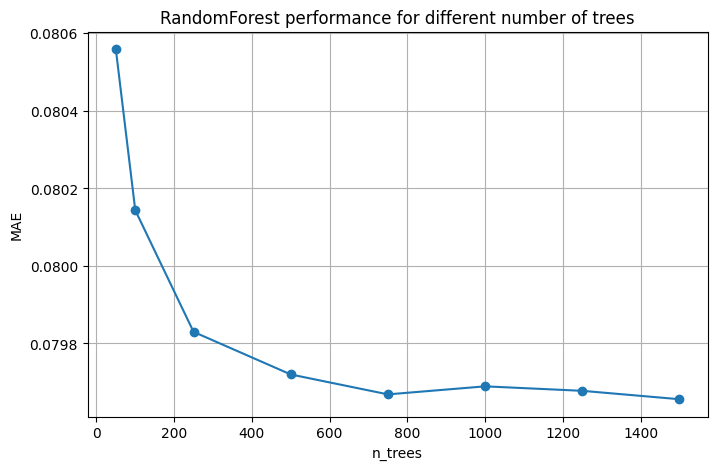

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(df_results["n_trees"], df_results["MAE"], marker='o')
plt.xlabel("n_trees")
plt.ylabel("MAE")
plt.title("RandomForest performance for different number of trees")
plt.grid(True)
plt.show()

#### MLP

In [18]:
def one_hot_encode(sequences, num_classes=4):
    return np.eye(num_classes)[sequences].reshape(len(sequences), -1)

# one-hot encoding
X_train_encoded = one_hot_encode(x_train)
X_val_encoded = one_hot_encode(x_val)
X_test_encoded = one_hot_encode(x_test)

# normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(f"Input feature size: {X_train_t.shape[1]}")

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define MLP model
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

model = MLPRegressor(input_dim=X_train_t.shape[1])
criterion = nn.MSELoss() # nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# train loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")
    
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_t).squeeze().numpy()
            val_mae = mean_absolute_error(y_val, y_val_pred)
            print(f"Validation MAE (Epoch {epoch+1}): {val_mae:.4f}")

Input feature size: 32


C:\Users\kroep\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kroep\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([56, 1, 1])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 0.0546
Epoch 2, Train Loss: 0.0356
Epoch 3, Train Loss: 0.0344
Epoch 4, Train Loss: 0.0337
Epoch 5, Train Loss: 0.0333
Validation MAE (Epoch 5): 0.1425


C:\Users\kroep\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kroep\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([56, 1, 1])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 6, Train Loss: 0.0330
Epoch 7, Train Loss: 0.0327
Epoch 8, Train Loss: 0.0325
Epoch 9, Train Loss: 0.0323
Epoch 10, Train Loss: 0.0322
Validation MAE (Epoch 10): 0.1437


C:\Users\kroep\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kroep\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([56, 1, 1])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 11, Train Loss: 0.0321
Epoch 12, Train Loss: 0.0320
Epoch 13, Train Loss: 0.0320
Epoch 14, Train Loss: 0.0319
Epoch 15, Train Loss: 0.0319
Validation MAE (Epoch 15): 0.1436


C:\Users\kroep\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kroep\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([56, 1, 1])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 16, Train Loss: 0.0318
Epoch 17, Train Loss: 0.0318
Epoch 18, Train Loss: 0.0318
Epoch 19, Train Loss: 0.0317
Epoch 20, Train Loss: 0.0317
Validation MAE (Epoch 20): 0.1453


#### RF and MLP on Test Set

In [20]:
rf_best = RandomForestRegressor(n_estimators=best_n_trees, random_state=42)
rf_best.fit(x_train, y_train.ravel())
y_pred_rf_test = rf_best.predict(x_test)
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)

In [21]:
mae_rf_test

0.07937943346940363

In [22]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_t).squeeze().numpy()
    mae_mlp_test = mean_absolute_error(y_test, y_test_pred)

In [23]:
mae_mlp_test

0.14064525